<a href="https://colab.research.google.com/github/San-lab-ship/prediccion_fuga_clientes_betabank/blob/main/BetaBank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# cargue de datos
import pandas as pd
from google.colab import files # Importa el módulo para subir archivos

print("Por favor, selecciona el archivo 'Churn.csv' desde tu equipo.")

try:
    # Abre un cuadro de diálogo para que selecciones el archivo.
    # Esto creará un botón "Choose Files" en la salida de la celda.
    uploaded = files.upload()

    # Itera sobre los nombres de los archivos subidos (normalmente solo uno).
    for filename in uploaded.keys():
        file_path = filename # El nombre del archivo subido es la ruta temporal

    # Carga el conjunto de datos usando el nombre del archivo subido
    df = pd.read_csv(file_path)

    print("\n¡Datos cargados exitosamente!")
    print(f"Las primeras 5 filas de tu dataset son:\n{df.head()}")
    print(f"\nLa forma de tu dataset (filas, columnas) es: {df.shape}")

except Exception as e:
    print(f"Ocurrió un error al cargar el archivo: {e}")
    print("Asegúrate de que el archivo subido es 'Churn.csv' y que es un archivo CSV válido.")


Por favor, selecciona el archivo 'Churn.csv' desde tu equipo.


Saving churn.csv to churn (3).csv

¡Datos cargados exitosamente!
Las primeras 5 filas de tu dataset son:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88      

In [14]:
# Equilibrio de Clases

# Equilibrio de Clases

import pandas as pd
import numpy as np

def analyze_class_balance_and_preprocess(df_input):
    """
    Realiza el preprocesamiento y el análisis del equilibrio de clases
    sobre un DataFrame ya cargado.

    Args:
        df_input (pd.DataFrame): El DataFrame de entrada que contiene los datos.

    Returns:
        tuple: Una tupla que contiene:
            - df (pd.DataFrame): El DataFrame preprocesado.
            - X (pd.DataFrame): Las características (features).
            - y (pd.Series): La variable objetivo.

    Raises:
        ValueError: Si la columna objetivo 'Exited' no se encuentra después del preprocesamiento.
        Exception: Si ocurre un error crítico durante el preprocesamiento o análisis.
    """
    try:
        # Usar el DataFrame de entrada directamente, sin volver a cargar
        df = df_input.copy() # Hacemos una copia para no modificar el DataFrame original

        columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
        df = df.drop(columns=columns_to_drop, errors='ignore')

        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        if categorical_cols:
            df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

        target_column_name = 'Exited'
        if target_column_name not in df.columns:
            raise ValueError(f"Error: La columna objetivo '{target_column_name}' no se encontró en el DataFrame después del preprocesamiento.")
        X = df.drop(target_column_name, axis=1)
        y = df[target_column_name]

        print("Distribución de la variable objetivo:")
        print(y.value_counts())

        print("\nPorcentaje de cada clase:")
        class_percentages = y.value_counts(normalize=True) * 100
        print(class_percentages.apply(lambda x: f"{x:.2f}%")) # Mantener formato para porcentaje

        minority_class_percentage = class_percentages.min()
        majority_class_percentage = class_percentages.max()

        if majority_class_percentage / minority_class_percentage > 2:
            print(f"\n¡Advertencia: Se detecta un desequilibrio de clases significativo!")
            print(f"La clase mayoritaria ({majority_class_percentage:.2f}%) es considerablemente más grande que la minoritaria ({minority_class_percentage:.2f}%).")
        else:
            print("\nEl equilibrio de clases parece razonable.")

    except Exception as e:
        # Se captura cualquier error durante el procesamiento del DataFrame
        raise Exception(f"Ocurrió un error crítico durante el preprocesamiento o análisis de equilibrio de clases: {e}")

    return df, X, y

# --- Uso de la función con el DataFrame ya cargado ---
# Asegúrate de que 'df' (tu DataFrame original cargado) exista en tu entorno de Colab.

try:
    # Pasamos el DataFrame 'df' (que ya debe estar cargado) a la función.
    df_processed_step2, X, y = analyze_class_balance_and_preprocess(df)

    print("\nPreprocesamiento y análisis de balance de clases completado con éxito.")
    print("Las variables 'df_processed_step2', 'X' y 'y' ahora están disponibles para su uso.")

except NameError:
    print("Error: La variable 'df' no está definida.")
    print("Por favor, asegúrate de haber ejecutado la celda anterior que carga el archivo 'Churn.csv' en la variable 'df'.")
except Exception as e:
    print(f"Error fatal durante el análisis o preprocesamiento: {e}")

Distribución de la variable objetivo:
Exited
0    7963
1    2037
Name: count, dtype: int64

Porcentaje de cada clase:
Exited
0    79.63%
1    20.37%
Name: proportion, dtype: object

¡Advertencia: Se detecta un desequilibrio de clases significativo!
La clase mayoritaria (79.63%) es considerablemente más grande que la minoritaria (20.37%).

Preprocesamiento y análisis de balance de clases completado con éxito.
Las variables 'df_processed_step2', 'X' y 'y' ahora están disponibles para su uso.


In [21]:
# Mejorando el modelo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Aunque no se usa en el código actual, es útil tenerla
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, confusion_matrix

def preprocess_data(df_input): # Cambiado a df_input para mayor claridad dentro de la función
    """
    Preprocesa el DataFrame: elimina columnas irrelevantes,
    maneja valores nulos y codifica variables categóricas.

    Args:
        df_input (pd.DataFrame): DataFrame ya cargado.

    Returns:
        tuple: X (features) y y (target).
    """
    df = df_input.copy() # Trabaja con una copia para no modificar el original

    columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
    df = df.drop(columns=columns_to_drop, errors='ignore') # Usar errors='ignore' es buena práctica

    # Identificación y manejo de columnas numéricas (para nulos e infinitos)
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    if 'Exited' in numerical_cols:
        numerical_cols.remove('Exited') # 'Exited' es la variable objetivo, no se imputa

    for col in numerical_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())
        if np.isinf(df[col]).any():
            # Reemplaza infinitos por NaN y luego imputa con la mediana
            df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(df[col].median())

    # Codificación de variables categóricas
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    if categorical_cols: # Solo si hay columnas categóricas
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True) # drop_first=True evita la multicolinealidad

    # Separación de características (X) y variable objetivo (y)
    X = df.drop('Exited', axis=1)
    y = df['Exited']
    return X, y

def split_data(X, y, test_size=0.20, val_size=0.25, random_state=12345):
    """
    Divide los datos en conjuntos de entrenamiento, validación y prueba.

    Args:
        X (pd.DataFrame): Características.
        y (pd.Series): Variable objetivo.
        test_size (float): Proporción del conjunto de prueba.
        val_size (float): Proporción del conjunto de validación del conjunto train_val.
        random_state (int): Semilla para la reproducibilidad.

    Returns:
        tuple: X_train, X_val, X_test, y_train, y_val, y_test.
    """
    # Primero, divide en entrenamiento+validación y prueba
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    # Luego, divide el conjunto de entrenamiento+validación en entrenamiento y validación
    # La proporción de val_size se aplica sobre X_train_val
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=random_state, stratify=y_train_val)
    print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
    print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
    print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")
    return X_train, X_val, X_test, y_train, y_val, y_test

def find_best_threshold(probabilities, true_labels):
    """
    Encuentra el umbral óptimo para la clasificación basado en la métrica F1.

    Args:
        probabilities (np.array): Probabilidades predichas para la clase positiva.
        true_labels (pd.Series or np.array): Etiquetas verdaderas.

    Returns:
        tuple: Mejor puntaje F1 y el umbral correspondiente.
    """
    best_f1 = 0
    best_threshold = 0.5 # Valor por defecto

    # Genera 100 umbrales entre 0 y 1
    thresholds = np.linspace(0, 1, 100)

    for threshold in thresholds:
        y_pred = (probabilities >= threshold).astype(int)
        # Evitar errores si una clase no está presente en la predicción con el umbral actual
        if len(np.unique(y_pred)) < 2:
            # Si solo se predice una clase, F1 score puede ser 0 o NaN, lo saltamos
            continue
        f1 = f1_score(true_labels, y_pred, zero_division=0) # zero_division=0 para evitar warnings
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_f1, best_threshold

def train_and_validate_models(X_train, y_train, X_val, y_val):
    """
    Entrena y valida diferentes modelos de clasificación, incluyendo
    ajuste de umbrales.

    Args:
        X_train (pd.DataFrame): Características de entrenamiento.
        y_train (pd.Series): Variable objetivo de entrenamiento.
        X_val (pd.DataFrame): Características de validación.
        y_val (pd.Series): Variable objetivo de validación.

    Returns:
        dict: Información del mejor modelo encontrado (F1 en validación).
    """
    results = []

    models_balanced = {
        "Logistic Regression": LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced'),
        "Decision Tree (Balanced)": DecisionTreeClassifier(random_state=12345, class_weight='balanced'),
        "Random Forest (Balanced)": RandomForestClassifier(random_state=12345, class_weight='balanced')}

    print("--- Entrenando y validando modelos con class_weight='balanced' ---")
    for name, model in models_balanced.items():
        model.fit(X_train, y_train)
        y_proba_val = model.predict_proba(X_val)[:, 1]

        # Evaluación con umbral por defecto (0.5)
        y_pred_val = (y_proba_val > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred_val, zero_division=0)
        auc_roc = roc_auc_score(y_val, y_proba_val)

        results.append({
            "Model": name,
            "Technique": "class_weight='balanced'",
            "F1_Validation": f1,
            "AUC_ROC_Validation": auc_roc,
            "Best_Threshold": 0.5, # Aquí se mantiene el 0.5 ya que class_weight ajusta la clasificación directamente
            "Model_Object": model})
        print(f"Modelo: {name}, F1: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")

    dt_depths = range(1, 11)
    rf_estimators = [50, 100, 150, 200]

    print("\n--- Entrenando y validando Decision Tree con ajuste de umbral ---")
    best_f1_dt_threshold_adjusted = -1 # Renombrado para evitar confusión con el de class_weight
    best_model_dt_threshold_adjusted = None
    best_depth_dt_threshold_adjusted = None
    best_threshold_dt_threshold_adjusted = None

    for depth in dt_depths:
        # Aquí no se usa class_weight para ver el efecto puro del umbral
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
        model.fit(X_train, y_train)
        y_proba_val = model.predict_proba(X_val)[:, 1]
        f1, threshold = find_best_threshold(y_proba_val, y_val)
        if f1 > best_f1_dt_threshold_adjusted:
            best_f1_dt_threshold_adjusted = f1
            best_model_dt_threshold_adjusted = model
            best_depth_dt_threshold_adjusted = depth
            best_threshold_dt_threshold_adjusted = threshold
        print(f"  Depth={depth}, F1={f1:.4f}, Umbral={threshold:.2f}")

    auc_roc_dt_threshold_adjusted = roc_auc_score(y_val, best_model_dt_threshold_adjusted.predict_proba(X_val)[:, 1])
    results.append({
        "Model": f"Decision Tree (Depth={best_depth_dt_threshold_adjusted})",
        "Technique": "Threshold Adjustment",
        "F1_Validation": best_f1_dt_threshold_adjusted,
        "AUC_ROC_Validation": auc_roc_dt_threshold_adjusted,
        "Best_Threshold": best_threshold_dt_threshold_adjusted,
        "Model_Object": best_model_dt_threshold_adjusted})


    print("\n--- Entrenando y validando Random Forest con ajuste de umbral ---")
    best_f1_rf_threshold_adjusted = -1
    best_model_rf_threshold_adjusted = None
    best_estimators_rf_threshold_adjusted = None
    best_threshold_rf_threshold_adjusted = None

    for est in rf_estimators:
        # Aquí no se usa class_weight para ver el efecto puro del umbral
        model = RandomForestClassifier(random_state=12345, n_estimators=est)
        model.fit(X_train, y_train)
        y_proba_val = model.predict_proba(X_val)[:, 1]
        f1, threshold = find_best_threshold(y_proba_val, y_val)
        if f1 > best_f1_rf_threshold_adjusted:
            best_f1_rf_threshold_adjusted = f1
            best_model_rf_threshold_adjusted = model
            best_estimators_rf_threshold_adjusted = est
            best_threshold_rf_threshold_adjusted = threshold
        print(f"  Estimators={est}, F1={f1:.4f}, Umbral={threshold:.2f}")

    auc_roc_rf_threshold_adjusted = roc_auc_score(y_val, best_model_rf_threshold_adjusted.predict_proba(X_val)[:, 1])
    results.append({
        "Model": f"Random Forest (Estimators={best_estimators_rf_threshold_adjusted})",
        "Technique": "Threshold Adjustment",
        "F1_Validation": best_f1_rf_threshold_adjusted,
        "AUC_ROC_Validation": auc_roc_rf_threshold_adjusted,
        "Best_Threshold": best_threshold_rf_threshold_adjusted,
        "Model_Object": best_model_rf_threshold_adjusted})


    best_model_info = max(results, key=lambda x: x['F1_Validation'])

    print("\n--- Resumen de los Resultados de Validación ---")
    print(f"Mejor Modelo: {best_model_info['Model']}")
    print(f"Técnica: {best_model_info['Technique']}")
    print(f"F1 de Validación: {best_model_info['F1_Validation']:.4f}")
    print(f"AUC-ROC de Validación: {best_model_info['AUC_ROC_Validation']:.4f}")
    print(f"Umbral Óptimo (si aplica): {best_model_info['Best_Threshold']:.2f}")
    print("-" * 50)

    return best_model_info

try:
    # 1. Preprocesar los datos (usando el 'df' que ya está cargado)
    X, y = preprocess_data(df) # Pasamos el 'df' existente aquí

    # 2. Dividir los datos
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    # 3. Entrenar y validar modelos
    best_model_info = train_and_validate_models(X_train, y_train, X_val, y_val)


except NameError:
    print("Error: La variable 'df' no está definida.")
    print("Por favor, asegúrate de haber ejecutado la celda anterior que carga el archivo 'Churn.csv' en la variable 'df'.")
except Exception as e:
    print(f"Error fatal inesperado: {e}")

Tamaño del conjunto de entrenamiento: 6000
Tamaño del conjunto de validación: 2000
Tamaño del conjunto de prueba: 2000
--- Entrenando y validando modelos con class_weight='balanced' ---
Modelo: Logistic Regression, F1: 0.4983, AUC-ROC: 0.7845
Modelo: Decision Tree (Balanced), F1: 0.4994, AUC-ROC: 0.6860
Modelo: Random Forest (Balanced), F1: 0.5571, AUC-ROC: 0.8555

--- Entrenando y validando Decision Tree con ajuste de umbral ---
  Depth=1, F1=0.5114, Umbral=0.13
  Depth=2, F1=0.5321, Umbral=0.12
  Depth=3, F1=0.5420, Umbral=0.23
  Depth=4, F1=0.5623, Umbral=0.14
  Depth=5, F1=0.5863, Umbral=0.24
  Depth=6, F1=0.5781, Umbral=0.27
  Depth=7, F1=0.5932, Umbral=0.32
  Depth=8, F1=0.5929, Umbral=0.33
  Depth=9, F1=0.5903, Umbral=0.35
  Depth=10, F1=0.5721, Umbral=0.31

--- Entrenando y validando Random Forest con ajuste de umbral ---
  Estimators=50, F1=0.6259, Umbral=0.32
  Estimators=100, F1=0.6312, Umbral=0.30
  Estimators=150, F1=0.6246, Umbral=0.30
  Estimators=200, F1=0.6270, Umbral=


--- Ejecutando Paso 5: Prueba Final del Modelo ---

Resultados del **Paso 5: Prueba Final** con el Modelo Seleccionado (Random Forest (Estimators=100)):
**F1-Score:** 0.6188
**AUC-ROC:** 0.8610

--- Informe de Clasificación Detallado de la **Prueba Final** ---
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1593
           1       0.59      0.66      0.62       407

    accuracy                           0.84      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.84      0.84      0.84      2000


--- Matriz de Confusión de la **Prueba Final** ---
[[1404  189]
 [ 140  267]]


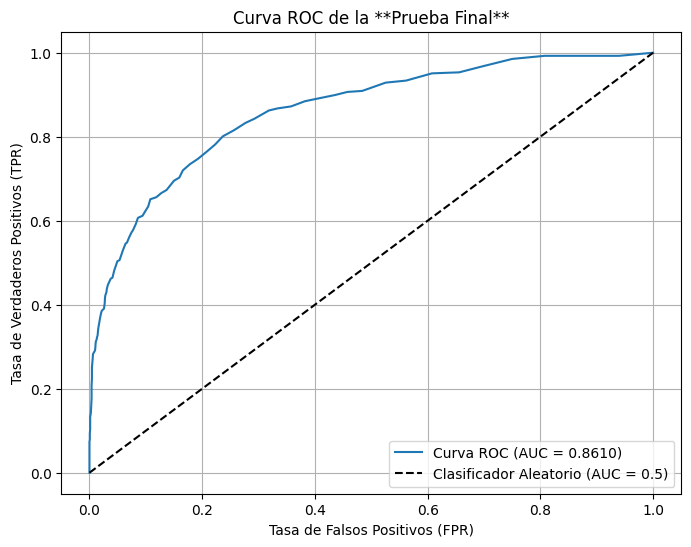

In [18]:
# Prueba Final del Modelo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, confusion_matrix

def run_final_test(best_model_info, X_test, y_test):
    """
    Realiza la prueba final del modelo.
    Asume que el mejor modelo y su umbral óptimo ya han sido determinados
    y que X_test y y_test ya están preprocesados y listos.

    Args:
        best_model_info (dict): Diccionario que contiene información del mejor modelo
                                (incluyendo 'Model_Object', 'Best_Threshold', 'Model').
        X_test (pd.DataFrame): Características del conjunto de prueba.
        y_test (pd.Series): Variable objetivo del conjunto de prueba.
    """
    if not best_model_info:
        print("No se pudo obtener la información del mejor modelo para la prueba final.")
        return

    # Extraer el mejor modelo, su umbral y nombre del diccionario
    best_model = best_model_info['Model_Object']
    best_threshold = best_model_info['Best_Threshold']
    model_name = best_model_info['Model']

    # Predecir probabilidades en el conjunto de prueba
    y_proba_final = best_model.predict_proba(X_test)[:, 1]

    # Aplicar el umbral óptimo para obtener las predicciones binarias
    y_pred_final = (y_proba_final >= best_threshold).astype(int)

    print("\n" + "="*80) # Separador visual
    print(f"Resultados del **Paso 5: Prueba Final** con el Modelo Seleccionado ({model_name}):")
    print(f"**F1-Score:** {f1_score(y_test, y_pred_final):.4f}")
    print(f"**AUC-ROC:** {roc_auc_score(y_test, y_proba_final):.4f}")

    print("\n--- Informe de Clasificación Detallado de la **Prueba Final** ---")
    print(classification_report(y_test, y_pred_final))

    print("\n--- Matriz de Confusión de la **Prueba Final** ---")
    print(confusion_matrix(y_test, y_pred_final))


    # Gráfico de la Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_final)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_score(y_test, y_proba_final):.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio (AUC = 0.5)')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC de la **Prueba Final**')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()



# --- Ejecución del Flujo de Prueba Final ---
try:
    print("\n--- Ejecutando Paso 5: Prueba Final del Modelo ---")
    run_final_test(best_model_info, X_test, y_test)

except NameError as e:
    print(f"Error: Una o más variables (X_test, y_test o best_model_info) no están definidas.")
    print("Asegúrate de haber ejecutado las celdas/secciones anteriores que cargan, dividen y entrenan los datos, y que definen 'best_model_info'.")
    print(f"Detalle del error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado durante la prueba final: {e}")